### Calculate and plot the seasonal climatology of Southern Ocean chlorophyll-a from GlobColour

In [21]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import utils.geo as geo
from dask.diagnostics import ProgressBar

In [22]:
import matplotlib as mpl
mpl.rcParams['font.size']=18
# mpl.rcParams['font.family']='serif'
# mpl.rcParams['font.serif']='Times'
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['legend.fontsize']=14

Note that this notebook makes use of my `utils` package, available [here](https://github.com/gmacgilchrist/utils)

## Working from processed globcolour data (daily, interpolated)
Processed in `calc_spatialmean_globcolour_daily.ipynb` and data saved here: `../../data/globcolour_cmems_daily_CHL_wmean-latlon_byyear-JULtoJUN.nc`

In [23]:
smooth = True
basins = True

In [24]:
dataset = 'globcolour-cmems'
frequency = 'day'
variable = 'CHL1'
yearstart = 1999
yearend = 2023
monthorder = 'JULtoJUN'
averaging = 'wmean-latlon'

outdir = '../../data/'
yearstr = str(yearstart)+'-'+str(yearend)
outpath = outdir+'.'.join([dataset,frequency,averaging,monthorder,yearstr,'nc'])

In [25]:
outpath

'../../data/globcolour-cmems.day.wmean-latlon.JULtoJUN.1999-2023.nc'

In [26]:
ds = xr.open_dataset(outpath)
smoothval = 14
if smooth:
    ds = ds.rolling(day=smoothval,center=True).mean()

In [27]:
ds

<xarray.Dataset>
Dimensions:  (year: 25, day: 365)
Coordinates:
  * year     (year) int64 1999 2000 2001 2002 2003 ... 2019 2020 2021 2022 2023
  * day      (day) int64 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364
Data variables:
    CHL1     (day, year) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [28]:
climatology = [2003,2023]

In [29]:
if basins:
    bs = xr.Dataset()
    for basin in ['epacific','wpacific','indian','atlantic']:
        outpath = outdir+'.'.join([dataset,frequency,averaging,monthorder,yearstr,basin,'nc'])
        bs[basin] = xr.open_dataarray(outpath)
    smooth = True
    smoothval = 14
    if smooth:
        bs = bs.rolling(day=smoothval,center=True).mean()
    anoms = bs.sel(year=climatology[1])-bs.sel(year=slice(climatology[0],climatology[1])).mean('year')

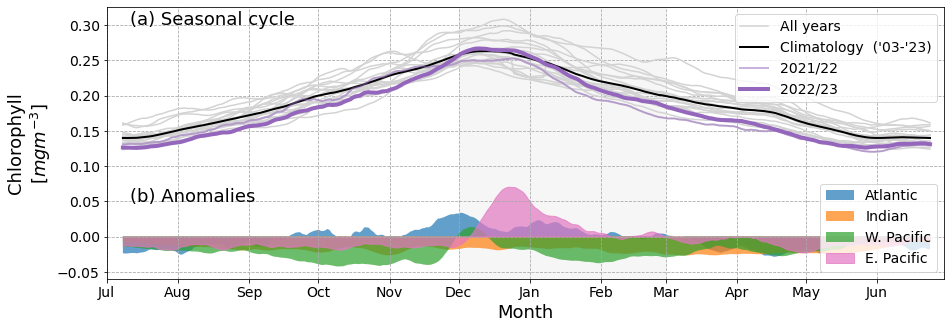

In [32]:
fig,ax = plt.subplots(figsize=(15,5))
# All years
for year in np.arange(climatology[0],climatology[1]):#ds['year'][:-1]:
    h, = ax.plot(ds['day'],ds[variable].sel(year=year),color='lightgray',label='All years')
# Climatology
ds_clim = ds.sel(year=slice(climatology[0],climatology[1])).mean('year')
h1, = ax.plot(ds_clim['day'],ds_clim[variable],color='black',linewidth=2,label="Climatology  ('"+str(climatology[0])[-2:]+"-'"+str(climatology[1])[-2:]+")")
# 2022
h2, = ax.plot(ds['day'],ds[variable].sel(year=yearend-1),color='tab:purple',linewidth=2,alpha=0.5,label='2021/22')
# 2023
h3, = ax.plot(ds['day'],ds[variable].sel(year=yearend),color='tab:purple',linewidth=4,label='2022/23')

monthname = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
monthlength = np.array([31,31,30,31,30,31,31,28,31,30,31,30])
monthday = np.append(np.array([0]),np.cumsum(monthlength))
ax.set_xticks(monthday[:-1])
ax.set_xticklabels(monthname)
ax.set_xlim(0,364)
ax.set_xlabel('Month')
ax.set_ylabel('Chlorophyll\n[$mgm^{-3}$]')#,rotation=0,ha='right',y=0.8)
ax.grid(linestyle='--',color='darkgray')

ax.text(10,0.3,'(a) Seasonal cycle')

l1 = ax.legend(handles=[h,h1,h2,h3],loc='upper right')

if basins:
    anomtot = ds[variable].sel(year=2022) - ds_clim[variable]
#     ax.plot(anomtot['day'],anomtot,color='k',linestyle='--')
    # Basin anomalies
    plot_kwargs = {'alpha':0.7}
    b1 = ax.fill_between(anoms['day'],anoms['atlantic'],label='Atlantic',**plot_kwargs)
    b2 = ax.fill_between(anoms['day'],anoms['indian'],label='Indian',**plot_kwargs)
    b3 = ax.fill_between(anoms['day'],anoms['wpacific'],label='W. Pacific',**plot_kwargs)
    b4 = ax.fill_between(anoms['day'],anoms['epacific'],label='E. Pacific',**plot_kwargs,color='tab:pink')

    ax.text(10,0.05,'(b) Anomalies')

    ax.legend(handles=[b1,b2,b3,b4],loc='lower right')
    ax.add_artist(l1)
    # ax.legend(bbox_to_anchor=(1,1))

ax.axvspan(monthday[5],monthday[8], color='lightgray', alpha=0.2, lw=0, zorder=0)

climstr = str(climatology[0])+'-'+str(climatology[1])
savename = '.'.join(['seasonal-climatology',dataset,frequency,variable,climstr])
if smooth:
    savename = savename+'.smooth-'+str(smoothval)
if basins:
    savename = savename+'.basins'
fig.savefig('../../figures/'+savename+'.pdf')#,dpi=300,transparent=True)